<img src='pics/otus.png'>

In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
fn = 'orders.csv'

In [3]:
# Данные касаются продаж книжного интернет-магазина
!head $fn

DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
23.55%,Хроники Амбера. Том 2,357.0,1,2017-03-19 22:25:20,110.0,169108,602051,1,527.0,911531
4.07%,Хроники Амбера. Том 1,448.0,1,2017-03-19 22:19:58,19.0,1394744,602047,1,618.0,911531
4.17%,Пищеводитель,414.0,1,2017-03-19 20:58:00,65.0,191276,602017,4,1503.0,911587
4.17%,"Аудиокн. Мясников. &quot;Ржавчина&quot;: что делать, чтобы сердце не болело",253.0,1,2017-03-19 20:58:00,65.0,157945,602017,4,1503.0,911587
4.09%,Инфекции. Как защитить себя и своего ребенка,422.0,1,2017-03-19 20:58:00,65.0,205173,602017,4,1503.0,911587
4.17%,О самом главном с доктором Мясниковым,414.0,1,2017-03-19 20:58:00,65.0,189415,602017,4,1503.0,911587
4.12%,Пеппи Длинныйчулок собирается в путь,489.0,1,2017-03-19 20:53:51,42.0,168183,602015,2,1238.0,201724
4.12%,Пеппи Длинныйчулок в стране Веселии,489.0,1,2017-03-19 20:53:51,42.0,186112,602015,2,1238.0,201724
4.09%,Серебряный шар. Драма за сценой,586.0,1,2017-0

# 1. Провести EDA
Просмотреть структуру данных, значения каждого признака, поискать особенности в признаках и в данных вцелом

In [4]:
df = pd.read_csv(fn, na_values='NaN')
df.head(5)

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
0,23.55%,Хроники Амбера. Том 2,357.00,1,2017-03-19 22:25:20,110.00,169108,602051,1,527.00,911531
1,4.07%,Хроники Амбера. Том 1,448.00,1,2017-03-19 22:19:58,19.00,1394744,602047,1,618.00,911531
2,4.17%,Пищеводитель,414.00,1,2017-03-19 20:58:00,65.00,191276,602017,4,1503.00,911587
3,4.17%,Аудиокн. Мясников. &quot;Ржавчина&quot;: что д...,253.00,1,2017-03-19 20:58:00,65.00,157945,602017,4,1503.00,911587
4,4.09%,Инфекции. Как защитить себя и своего ребенка,422.00,1,2017-03-19 20:58:00,65.00,205173,602017,4,1503.00,911587


In [5]:
# Дубликаты
df.duplicated().sum()

10

In [6]:
df.drop_duplicates(inplace = True)

Представлены следующие данные:

- DISCOUNT_VALUE - величина скидки, %;
- NAME - название книги;
- PRICE - стоимость одного экземпляра книги;
- QUANTITY - количество заказанных экземпляров книги;
- data_inser - дата и время размещения (?) заказа;
- discount - рассчитанная стоимость скидки. Расчётная формула, по-видимому, следующая:
discount = PRICE * DISCOUNT_VALUE / (1 - DISCOUNT_VALUE);
- itemID - идентификатор товара (книги);
- orderID - идентификатор заказа;
- ordered_item_count - количество товаров в данном заказе;
- price - общая стоимость заказа (видимо, с учётом доставки?);
- user_id - идентификатор клиента.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557808 entries, 0 to 557817
Data columns (total 11 columns):
DISCOUNT_VALUE        553771 non-null object
NAME                  557801 non-null object
PRICE                 557808 non-null float64
QUANTITY              557808 non-null int64
date_insert           557808 non-null object
discount              557808 non-null float64
itemID                557808 non-null int64
orderID               557808 non-null int64
ordered_item_count    557808 non-null int64
price                 557808 non-null float64
user_id               557808 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 51.1+ MB


In [8]:
# Количество уникальных пользователей, делавших заказы
df['user_id'].nunique()

76258

In [9]:
# Количество уникальных книг (по id)
df['itemID'].nunique()

51890

In [10]:
df['NAME'].nunique()

74632

Т.к. уникальных id товаров меньше, чем уникальных названий, то скорее всего в названиях встречаются неточности (из-за чего они получаются отличающимися)

In [11]:
# Встречаются такие довольно загадочные данные с отрицательной скидкой
df[df['orderID'] == 601300]

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
190,NaN,"Кыш, Двапортфеля и целая неделя. Кыш и я в Кры...",437.00,1,2017-03-18 11:15:09,-823.00,198440,601300,2,1102.00,910987
191,NaN,В Стране Вечных Каникул. Саша и Шура (вес: 640...,386.00,1,2017-03-18 11:15:09,-823.00,200733,601300,2,1102.00,910987


In [12]:
# Удалим в столбце скидки знак процента, чтобы данные использовать в числовой форме
df['DISCOUNT_VALUE'] = pd.to_numeric(df['DISCOUNT_VALUE'].str.replace('%', ''))

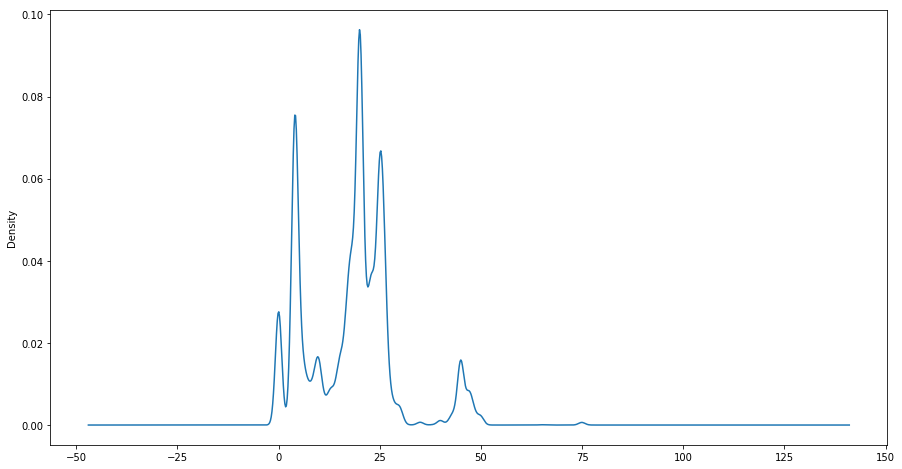

In [13]:
df['DISCOUNT_VALUE'].plot.kde()

В распределении скидки видно несколько пиков, в районе 5 %, 20 % и 40 %.

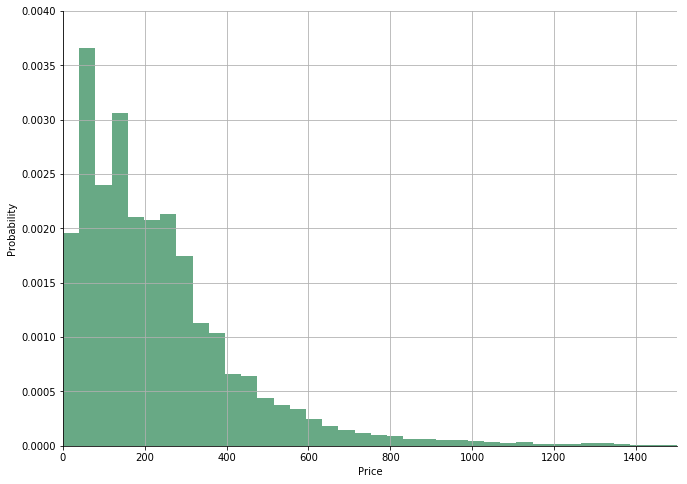

In [14]:
# График распределения цены книги

fig, ax = plt.subplots(1, 1, figsize=(11, 8))

# the histogram of the speed
n, bins, patches = plt.hist(df['PRICE'], 500, normed=1, facecolor='#368d5c', alpha=0.75)

plt.xlabel('Price', fontsize = 10)
plt.ylabel('Probability', fontsize = 10)
plt.axis([0, 1500, 0, 0.004])
plt.grid(True)

ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.show()

In [15]:
# Даты преобразуем из строкового представления в формат даты
df['date_insert'] = pd.to_datetime(df['date_insert'])

In [16]:
# Рассмотрим интенсивность покупок по времени (сгруппируем заказы по дням и по месяцам)
df_group_by_day = df.groupby(df['date_insert'].map(lambda x: x.date()))['ordered_item_count'].sum()

In [17]:
df_group_by_day.head()

date_insert
2017-03-13    11450
2017-03-14    50197
2017-03-15    81753
2017-03-16    71921
2017-03-17    40466
Name: ordered_item_count, dtype: int64

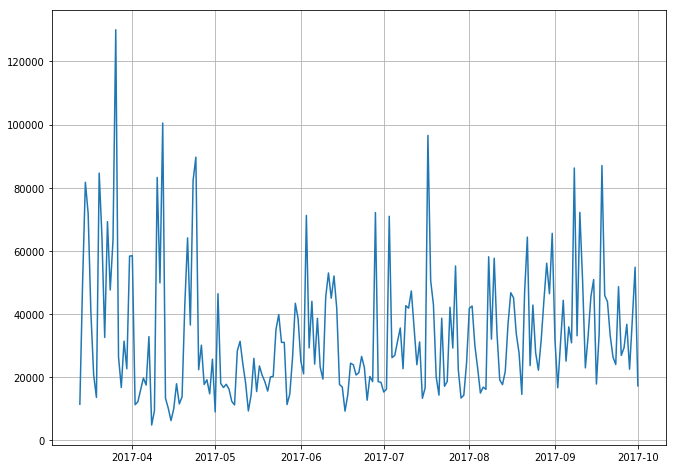

In [18]:
# Видим, что никакой особой зависимости не наблюдается...
fig, ax = plt.subplots(1, 1, figsize=(11, 8))
plt.grid()
ax.plot(df_group_by_day)

In [19]:
# Сгруппируем стоимость заказов пользователей
price_by_user = df.groupby(['user_id'])['price'].sum()
price_by_user.describe()

count      76258.00
mean       20461.55
std       238496.76
min            3.00
25%          984.85
50%         3688.00
75%        10833.98
max     31763867.00
Name: price, dtype: float64

In [20]:
# Сгруппируем количество заказов пользователей
ordered_item_count_by_user = df.groupby(['user_id'])['ordered_item_count'].sum()
ordered_item_count_by_user.describe()

count    76258.00
mean        88.89
std        953.18
min          1.00
25%          1.00
50%          9.00
75%         36.00
max     103570.00
Name: ordered_item_count, dtype: float64

Похоже в данных выделяются некие оптовые покупатели, приобретающие большое количество книг...

### Попытаемся проанализировать названия книг...

In [6]:
# Приводим названия книг к нижнему регистру
df['NAME'] = df['NAME'].map(lambda x: str(x).decode('utf8').lower())

# 2. Спланировать эксперимент 

Задача:
* сегментация товаров + сегментация пользователей (по товарам, по поведению, скидкам и пр.)

Дополнительнительные задачи:
* поиск товаров-заменителей и товаров, дополняющих друг друга
* поиск выбросов среди товаров
* поиск выбросов среди заказов

Эксперимент:
* Составить первичный список признаков, необходимых для решения задачи
* Сгенерировать список новых признаков, которые можно получить из данных
* Применить понижение размерности для визуализации данных
* Применить кластеризацию, визуализировать
* Описание кластера
* Любые другие пункты

# 3. Выполнить подготовку данных для построения модели

Выполнить необходимые преобразования данных

# 4. Провести построение модели 

# 5. Проанализировать результат
получилось или нет, почему, что можно улучшить, можно ли интерпретировать результат

# 6. Повторить при необходимости 

# Подсказки

* Проводить EDA и работу с признаками на всем датасете
* Для построения модели отсеивать данные тем или иным способом (обосновать выбор) - уменьшить объем данных для анализа
* Оформлять для сдачи задания все эксперименты (в том числе неудачные). Так мы сможем увидеть процесс работы над заданием
* Не тратить 90% времени на первый этап. Планировать время так, чтобы успеть поработать над моделью (в равной степени над каждым пунктом).